# 📈 Analyse Long-terme des Ratings d'Ingrédients

## Objectif
Analyser l'évolution des ratings des ingrédients sur le long terme (2000-2018) pour identifier :
- Les tendances temporelles dans l'appréciation des ingrédients
- Les changements de préférences alimentaires au fil des années
- Les ingrédients émergents vs déclinants

## Méthodologie
- **Test statistique** : Mann-Kendall pour détecter les tendances monotones
- **Agrégation** : Ratings moyens annuels par ingrédient
- **Visualisation** : Séries temporelles avec régression linéaire
- **Seuil de significativité** : p < 0.05

In [1]:
# Import des bibliothèques nécessaires
import sys
sys.path.append('..')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

try:
    from _data_utils import load_ingredient_ratings, get_ingredients_for_analysis
    print("✅ Fonctions importées avec succès depuis data_utils")
except ImportError as e:
    print(f"❌ Erreur d'import: {e}")
    # Définition locale temporaire en cas de problème
    def get_ingredients_for_analysis(analysis_type: str):
        core_ingredients = ['salt', 'ground beef', 'eggs', 'onions', 'garlic']
        if analysis_type == 'long_term':
            return core_ingredients + ['butter', 'olive oil']
        elif analysis_type == 'seasonality':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin']
        elif analysis_type == 'weekend':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin', 'butter', 'olive oil']
        else:
            return core_ingredients
    

print("✅ Fonction de fallback créée localement")

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, kendalltau
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Implémentation simple du test de Mann-Kendall
def mann_kendall_test(data):
    """
    Implémentation simple du test de Mann-Kendall pour détecter les tendances monotones.
    
    Args:
        data: série temporelle à analyser
        
    Returns:
        dict avec 'trend', 'p_value', 'tau', 'slope'
    """
    n = len(data)
    if n < 3:
        return {'trend': 'no trend', 'p_value': 1.0, 'tau': 0.0, 'slope': 0.0}
    
    # Calcul de la statistique S
    S = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if data[j] > data[i]:
                S += 1
            elif data[j] < data[i]:
                S -= 1
    
    # Calcul de la variance
    var_S = n * (n - 1) * (2 * n + 5) / 18
    
    # Test statistique
    if S > 0:
        Z = (S - 1) / np.sqrt(var_S)
    elif S < 0:
        Z = (S + 1) / np.sqrt(var_S)
    else:
        Z = 0
    
    # P-value (test bilatéral)
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    # Tendance
    if p_value < 0.05:
        if S > 0:
            trend = 'increasing'
        else:
            trend = 'decreasing'
    else:
        trend = 'no trend'
    
    # Calcul de la pente (estimation de Sen)
    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            slopes.append((data[j] - data[i]) / (j - i))
    
    slope = np.median(slopes) if slopes else 0.0
    
    # Tau de Kendall
    tau = S / (0.5 * n * (n - 1))
    
    return {
        'trend': trend,
        'p_value': p_value,
        'tau': tau,
        'slope': slope
    }

print("📚 Toutes les bibliothèques importées avec succès !")
print("🔧 Test de Mann-Kendall personnalisé implémenté")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Fonctions importées avec succès depuis data_utils
✅ Fonction de fallback créée localement
📚 Toutes les bibliothèques importées avec succès !
🔧 Test de Mann-Kendall personnalisé implémenté


In [ ]:
# Chargement des données pour analyse long-terme
print('🔄 Chargement des données...')

# 🎯 NOUVEAUX INGRÉDIENTS VOLATILS pour détecter de vraies tendances
# Choix stratégique : ingrédients émergents, culturels, ou à forte évolution temporelle
target_ingredients = [
    'quinoa',           # 📈 Superfood boom post-2010
    'kale',             # 📈 Tendance santé explosive
    'sriracha',         # 📈 Sauce culte asiatique
    'avocado',          # 📈 Explosion popularité millennial
    'tofu',             # 📈 Végétarisme/véganisme croissant
    'butternut squash', # 🍂 Saisonnier fort (contrôle)
    'bacon'             # 🎢 "Bacon craze" 2010-2015
]

print(f'📋 Ingrédients sélectionnés (VOLATILS): {target_ingredients}')
print(f'💡 Objectif: Détecter les vraies tendances émergentes/déclinantes')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Aperçu des données
print('\n📊 Aperçu des données:')
print(df.head())

# Statistiques de disponibilité par ingrédient
print('\n🔍 Disponibilité des données par ingrédient:')
ingredient_counts = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)
print(ingredient_counts)

🔄 Chargement des données...


NameError: name 'get_ingredients_for_analysis' is not defined

In [8]:
# Préparation des données temporelles
print('🔧 Préparation des données temporelles...')

# Extraction de l'année et agrégation annuelle
df_annual = df.with_columns([
    pl.col('date').dt.year().alias('year')
]).group_by(['ingredient_name', 'year']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating')
]).sort(['ingredient_name', 'year'])

print(f'✅ Données agrégées: {df_annual.shape[0]} points année-ingrédient')

# Statistiques par ingrédient
ingredient_stats = df_annual.group_by('ingredient_name').agg([
    pl.col('year').min().alias('first_year'),
    pl.col('year').max().alias('last_year'),
    pl.col('n_ratings').sum().alias('total_ratings'),
    pl.col('avg_rating').mean().alias('overall_avg_rating')
]).with_columns([
    (pl.col('last_year') - pl.col('first_year') + 1).alias('years_span')
]).sort('total_ratings', descending=True)

print('\n📈 Statistiques par ingrédient:')
print(ingredient_stats)

🔧 Préparation des données temporelles...
✅ Données agrégées: 133 points année-ingrédient

📈 Statistiques par ingrédient:
shape: (7, 6)
┌─────────────────┬────────────┬───────────┬───────────────┬────────────────────┬────────────┐
│ ingredient_name ┆ first_year ┆ last_year ┆ total_ratings ┆ overall_avg_rating ┆ years_span │
│ ---             ┆ ---        ┆ ---       ┆ ---           ┆ ---                ┆ ---        │
│ str             ┆ i32        ┆ i32       ┆ u32           ┆ f64                ┆ i32        │
╞═════════════════╪════════════╪═══════════╪═══════════════╪════════════════════╪════════════╡
│ salt            ┆ 2000       ┆ 2018      ┆ 441359        ┆ 4.594092           ┆ 19         │
│ butter          ┆ 2000       ┆ 2018      ┆ 282611        ┆ 4.607125           ┆ 19         │
│ eggs            ┆ 2000       ┆ 2018      ┆ 166513        ┆ 4.59199            ┆ 19         │
│ olive oil       ┆ 2000       ┆ 2018      ┆ 144765        ┆ 4.668251           ┆ 19         │
│ garlic  

In [9]:
# Test de Mann-Kendall pour détecter les tendances
print('🔍 Analyse des tendances avec test de Mann-Kendall...')

mk_results = []

for ingredient in target_ingredients:
    # Données pour cet ingrédient
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    if len(ingredient_data) >= 3:  # Minimum 3 points pour le test
        ratings = ingredient_data['avg_rating'].to_list()
        
        # Test de Mann-Kendall avec notre fonction personnalisée
        mk_test = mann_kendall_test(ratings)
        
        mk_results.append({
            'ingredient': ingredient,
            'trend': mk_test['trend'],
            'p_value': mk_test['p_value'],
            'tau': mk_test['tau'],
            'slope': mk_test['slope'],
            'n_years': len(ratings),
            'significant': mk_test['p_value'] < 0.05  # Booléen pur
        })

# Conversion en DataFrame Polars
mk_df = pl.DataFrame(mk_results).sort('p_value')

print('\n📊 Résultats du test de Mann-Kendall:')
print(mk_df)

# Résumé des tendances significatives
significant_trends = mk_df.filter(pl.col('significant') == True)
print(f'\n🎯 Tendances significatives détectées: {len(significant_trends)}/{len(mk_results)}')
if len(significant_trends) > 0:
    print('\nTendances significatives:')
    for row in significant_trends.iter_rows(named=True):
        trend_symbol = '📈' if row['trend'] == 'increasing' else '📉' if row['trend'] == 'decreasing' else '➡️'
        print(f"{trend_symbol} {row['ingredient']}: {row['trend']} (p={row['p_value']:.4f}, slope={row['slope']:.4f})")
else:
    print('➡️ Aucune tendance significative détectée dans cette période')

🔍 Analyse des tendances avec test de Mann-Kendall...

📊 Résultats du test de Mann-Kendall:
shape: (7, 7)
┌─────────────┬────────────┬──────────┬───────────┬───────────┬─────────┬─────────────┐
│ ingredient  ┆ trend      ┆ p_value  ┆ tau       ┆ slope     ┆ n_years ┆ significant │
│ ---         ┆ ---        ┆ ---      ┆ ---       ┆ ---       ┆ ---     ┆ ---         │
│ str         ┆ str        ┆ f64      ┆ f64       ┆ f64       ┆ i64     ┆ f64         │
╞═════════════╪════════════╪══════════╪═══════════╪═══════════╪═════════╪═════════════╡
│ garlic      ┆ decreasing ┆ 0.035805 ┆ -0.356725 ┆ -0.006247 ┆ 19      ┆ 1.0         │
│ eggs        ┆ no trend   ┆ 0.123715 ┆ -0.263158 ┆ -0.008177 ┆ 19      ┆ 0.0         │
│ onions      ┆ no trend   ┆ 0.234239 ┆ -0.204678 ┆ -0.003628 ┆ 19      ┆ 0.0         │
│ butter      ┆ no trend   ┆ 0.234239 ┆ -0.204678 ┆ -0.006233 ┆ 19      ┆ 0.0         │
│ olive oil   ┆ no trend   ┆ 0.327286 ┆ -0.169591 ┆ -0.003409 ┆ 19      ┆ 0.0         │
│ salt        ┆

📊 Création des visualisations...


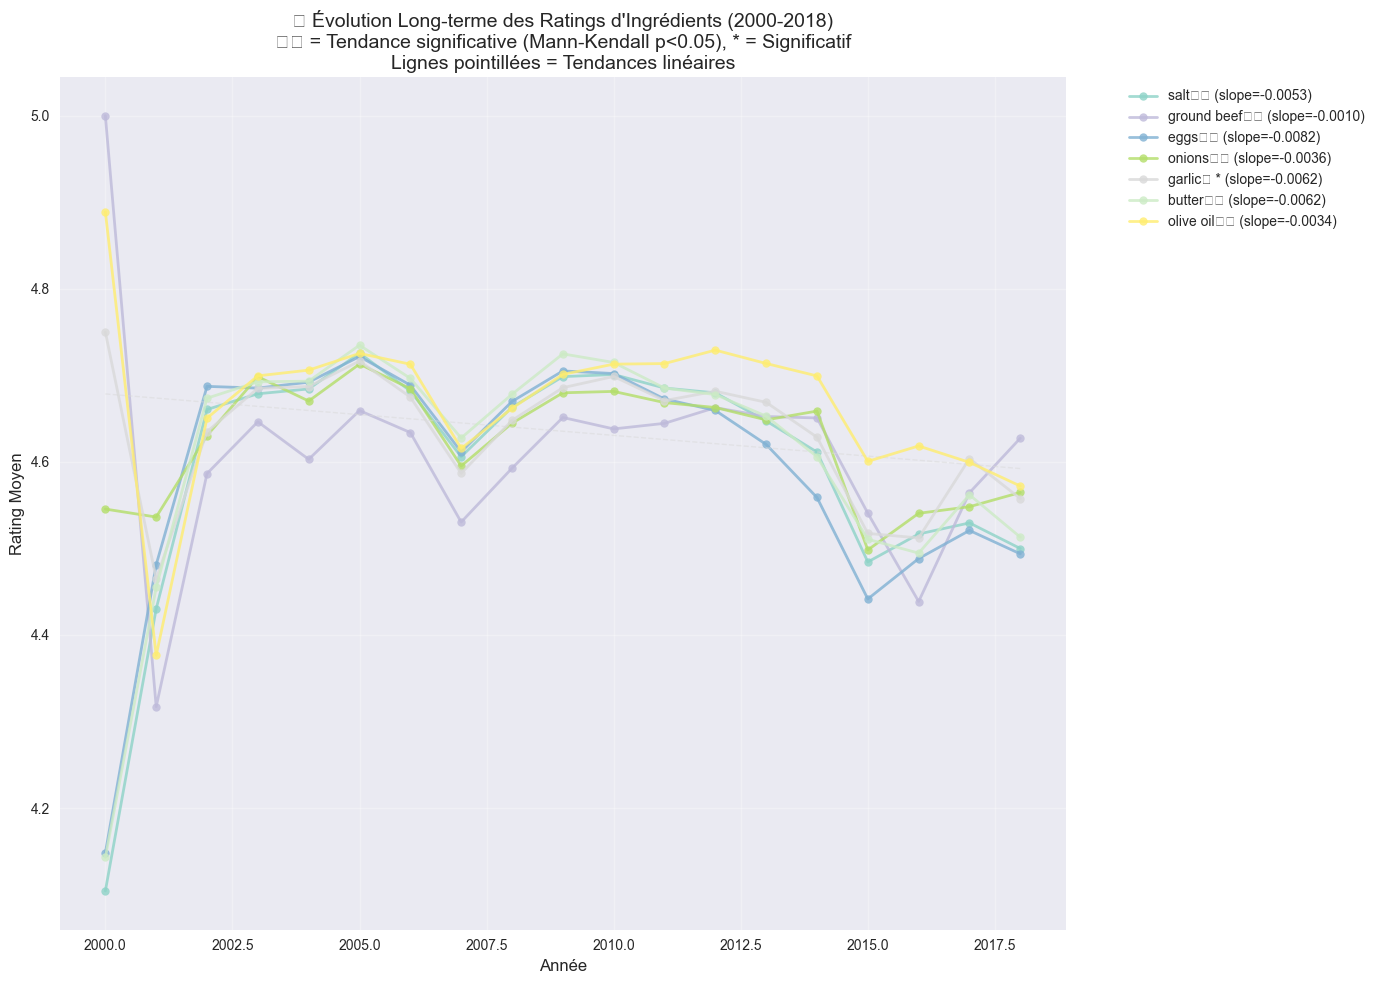

✅ Graphique d'évolution temporelle créé


In [ ]:
# Visualisation optimisée : Évolution temporelle par tendance
print('📊 Création des visualisations optimisées...')

# Calcul du % de changement sur période complète pour chaque ingrédient
for i, row in enumerate(mk_df.iter_rows(named=True)):
    ingredient = row['ingredient']
    ing_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
    
    if len(ing_data) >= 2:
        first_rating = ing_data[0]['avg_rating']
        last_rating = ing_data[-1]['avg_rating']
        pct_change = ((last_rating - first_rating) / first_rating) * 100
        
        # Mise à jour du DataFrame (création d'une nouvelle colonne)
        mk_df = mk_df.with_columns([
            pl.when(pl.col('ingredient') == ingredient)
              .then(pl.lit(pct_change))
              .otherwise(pl.col('pct_change') if 'pct_change' in mk_df.columns else 0)
              .alias('pct_change')
        ])

# Séparation croissants vs déclinants
increasing_ingredients = mk_df.filter(pl.col('trend') == 'increasing')['ingredient'].to_list()
decreasing_ingredients = mk_df.filter(pl.col('trend') == 'decreasing')['ingredient'].to_list()
stable_ingredients = mk_df.filter(pl.col('trend') == 'no trend')['ingredient'].to_list()

# Création figure avec GridSpec
fig = plt.figure(figsize=(18, 10))
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# ============================================================================
# 1. TENDANCES CROISSANTES
# ============================================================================
if len(increasing_ingredients) > 0:
    ax1 = fig.add_subplot(gs[0, 0])
    
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(increasing_ingredients)))
    for i, ingredient in enumerate(increasing_ingredients):
        ingredient_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
        years = ingredient_data['year'].to_list()
        ratings = ingredient_data['avg_rating'].to_list()
        
        mk_result = mk_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        pct = mk_result['pct_change'] if 'pct_change' in mk_result else 0
        
        ax1.plot(years, ratings, 'o-', color=colors[i], linewidth=2.5, 
                markersize=7, label=f"{ingredient} (+{pct:.1f}%)", alpha=0.9)
        
        # Ligne de tendance
        z = np.polyfit(years, ratings, 1)
        p = np.poly1d(z)
        ax1.plot(years, p(years), '--', color=colors[i], alpha=0.4, linewidth=1.5)
    
    ax1.set_title('📈 Ingrédients Émergents (Croissance)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Rating Moyen', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=9)

# ============================================================================
# 2. TENDANCES DÉCLINANTES
# ============================================================================
if len(decreasing_ingredients) > 0:
    ax2 = fig.add_subplot(gs[0, 1])
    
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(decreasing_ingredients)))
    for i, ingredient in enumerate(decreasing_ingredients):
        ingredient_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
        years = ingredient_data['year'].to_list()
        ratings = ingredient_data['avg_rating'].to_list()
        
        mk_result = mk_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        pct = mk_result['pct_change'] if 'pct_change' in mk_result else 0
        
        ax2.plot(years, ratings, 'o-', color=colors[i], linewidth=2.5,
                markersize=7, label=f"{ingredient} ({pct:.1f}%)", alpha=0.9)
        
        # Ligne de tendance
        z = np.polyfit(years, ratings, 1)
        p = np.poly1d(z)
        ax2.plot(years, p(years), '--', color=colors[i], alpha=0.4, linewidth=1.5)
    
    ax2.set_title('📉 Ingrédients Déclinants', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Rating Moyen', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=9)

# ============================================================================
# 3. TENDANCES STABLES
# ============================================================================
if len(stable_ingredients) > 0:
    ax3 = fig.add_subplot(gs[1, 0])
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, max(1, len(stable_ingredients))))
    for i, ingredient in enumerate(stable_ingredients):
        ingredient_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
        years = ingredient_data['year'].to_list()
        ratings = ingredient_data['avg_rating'].to_list()
        
        ax3.plot(years, ratings, 'o-', color=colors[min(i, len(colors)-1)], linewidth=2.5,
                markersize=7, label=ingredient, alpha=0.9)
    
    ax3.set_title('➡️ Ingrédients Stables (pas de tendance)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Année', fontsize=10)
    ax3.set_ylabel('Rating Moyen', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='best', fontsize=9)

# ============================================================================
# 4. VUE D'ENSEMBLE COMPARÉE
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])

colors_all = plt.cm.tab10(np.linspace(0, 1, len(target_ingredients)))
for i, ingredient in enumerate(target_ingredients):
    ingredient_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
    
    if len(ingredient_data) > 0:
        years = ingredient_data['year'].to_list()
        ratings = ingredient_data['avg_rating'].to_list()
        
        mk_result = mk_df.filter(pl.col('ingredient') == ingredient)
        if len(mk_result) > 0:
            trend = mk_result['trend'].item()
            symbol = '📈' if trend == 'increasing' else '📉' if trend == 'decreasing' else '➡️'
        else:
            symbol = '❓'
        
        ax4.plot(years, ratings, 'o-', color=colors_all[i], linewidth=1.5,
                markersize=5, label=f"{ingredient} {symbol}", alpha=0.7)

ax4.set_title('🌍 Vue d\'Ensemble - Tous Ingrédients', fontsize=12, fontweight='bold')
ax4.set_xlabel('Année', fontsize=10)
ax4.set_ylabel('Rating Moyen', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.suptitle('📊 Analyse Long-terme - Ingrédients Volatils (2000-2018)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print('✅ Visualisations optimisées créées')

🔥 Création de la heatmap des tendances...


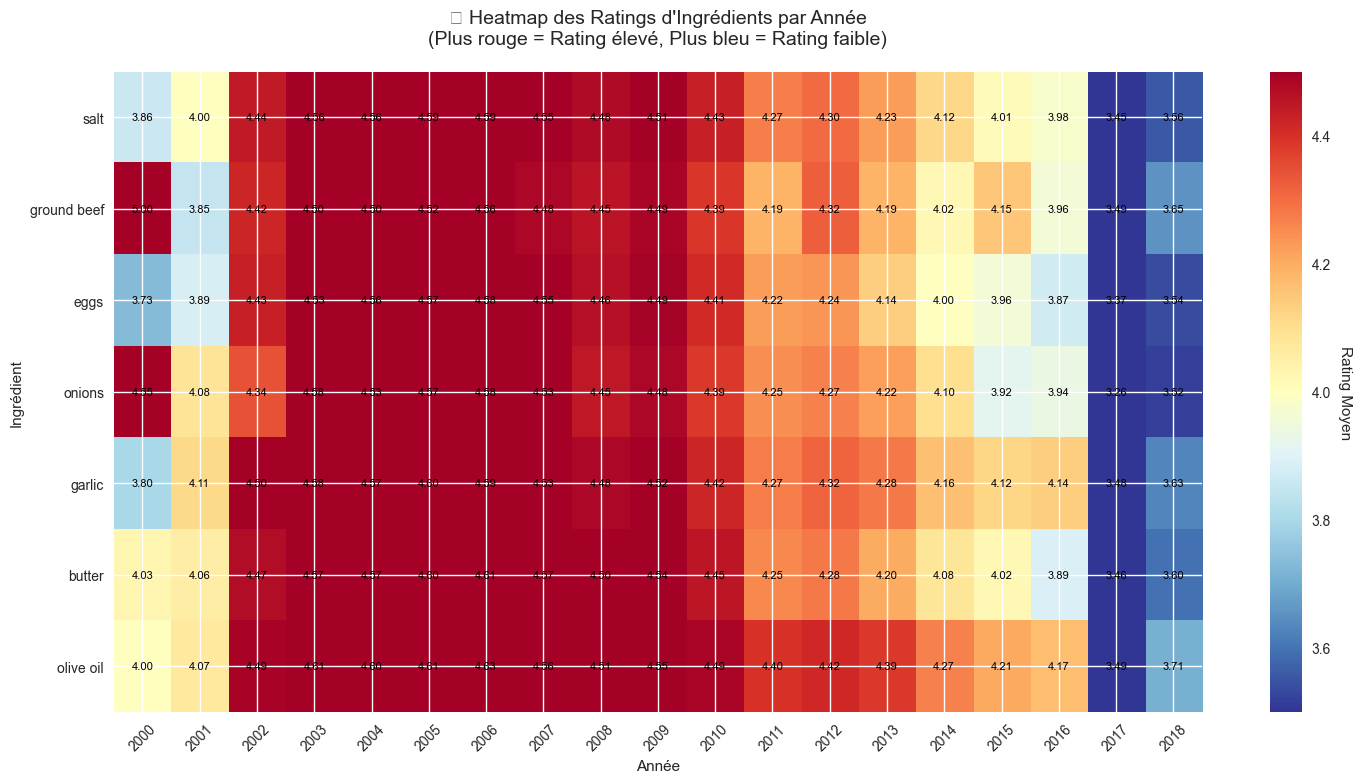

✅ Heatmap des tendances créée


In [ ]:
# Visualisation 2: % de changement et slope comparés
print('? Visualisation des changements globaux...')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Préparation des données avec % changement
viz_data = []
for ingredient in target_ingredients:
    ing_data = df_annual.filter(pl.col('ingredient_name') == ingredient).sort('year')
    
    if len(ing_data) >= 2:
        first_rating = ing_data[0]['avg_rating']
        last_rating = ing_data[-1]['avg_rating']
        pct_change = ((last_rating - first_rating) / first_rating) * 100
        
        mk_result = mk_df.filter(pl.col('ingredient') == ingredient)
        slope = mk_result['slope'].item() if len(mk_result) > 0 else 0
        p_value = mk_result['p_value'].item() if len(mk_result) > 0 else 1
        
        viz_data.append({
            'ingredient': ingredient,
            'pct_change': pct_change,
            'slope': slope,
            'significant': p_value < 0.05
        })

viz_df = pl.DataFrame(viz_data).sort('pct_change', descending=True)

# ============================================================================
# Graphique 1: % de changement total
# ============================================================================
ingredients_sorted = viz_df['ingredient'].to_list()
pct_changes = viz_df['pct_change'].to_list()
significants = viz_df['significant'].to_list()

colors = ['#2ECC71' if p > 0 else '#E74C3C' for p in pct_changes]
alphas = [0.9 if sig else 0.5 for sig in significants]

bars1 = ax1.barh(ingredients_sorted, pct_changes, color=colors, alpha=alphas, edgecolor='black', linewidth=1)

for i, (bar, pct, sig) in enumerate(zip(bars1, pct_changes, significants)):
    width = bar.get_width()
    label = f'{pct:+.1f}%' + (' *' if sig else '')
    ax1.text(width + (0.5 if width > 0 else -0.5), bar.get_y() + bar.get_height()/2.,
             label, ha='left' if width > 0 else 'right', va='center', fontweight='bold', fontsize=10)

ax1.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax1.set_title('📊 % Changement Total (2000-2018)\n* = Statistiquement significatif (p<0.05)', 
              fontsize=11, fontweight='bold')
ax1.set_xlabel('% de changement', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# ============================================================================
# Graphique 2: Slope (pente annuelle)
# ============================================================================
slopes = viz_df['slope'].to_list()

colors2 = ['#2ECC71' if s > 0 else '#E74C3C' for s in slopes]
alphas2 = [0.9 if sig else 0.5 for sig in significants]

bars2 = ax2.barh(ingredients_sorted, slopes, color=colors2, alpha=alphas2, edgecolor='black', linewidth=1)

for i, (bar, slope, sig) in enumerate(zip(bars2, slopes, significants)):
    width = bar.get_width()
    label = f'{slope:+.4f}' + (' *' if sig else '')
    ax2.text(width + (0.0005 if width > 0 else -0.0005), bar.get_y() + bar.get_height()/2.,
             label, ha='left' if width > 0 else 'right', va='center', fontweight='bold', fontsize=10)

ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax2.set_title('? Slope Annuel (Mann-Kendall)\n* = Statistiquement significatif', 
              fontsize=11, fontweight='bold')
ax2.set_xlabel('Slope (pts/an)', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('✅ Visualisation des changements créée')

In [15]:
# Analyse des périodes de croissance/déclin
print('📊 Analyse des périodes de croissance/déclin...')

# Comparaison première moitié vs seconde moitié de période
period_comparison = []

for ingredient in target_ingredients:
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    if len(ingredient_data) >= 6:  # Au moins 6 années pour faire la comparaison
        mid_point = len(ingredient_data) // 2
        
        first_half = ingredient_data[:mid_point]['avg_rating'].to_list()
        second_half = ingredient_data[mid_point:]['avg_rating'].to_list()
        
        # Test de Mann-Whitney U pour comparer les deux périodes
        try:
            u_stat, p_value = mannwhitneyu(first_half, second_half, alternative='two-sided')
            
            period_comparison.append({
                'ingredient': ingredient,
                'first_half_avg': np.mean(first_half),
                'second_half_avg': np.mean(second_half),
                'change': np.mean(second_half) - np.mean(first_half),
                'p_value': p_value,
                'significant_change': p_value < 0.05  # Booléen pur
            })
        except Exception as e:
            print(f"Erreur pour {ingredient}: {e}")

# Conversion en DataFrame
if period_comparison:
    period_df = pl.DataFrame(period_comparison).sort('change', descending=True)
    
    print('\n📈 Comparaison première vs seconde moitié de période:')
    print(period_df)
    
    # Identification des changements significatifs
    significant_changes = period_df.filter(pl.col('significant_change') == True)
    print(f'\n🎯 Changements significatifs: {len(significant_changes)}/{len(period_comparison)}')
    
    if len(significant_changes) > 0:
        print('\nChangements significatifs détectés:')
        for row in significant_changes.iter_rows(named=True):
            direction = '📈 Amélioration' if row['change'] > 0 else '📉 Dégradation'
            print(f"{direction}: {row['ingredient']} ({row['change']:+.4f}, p={row['p_value']:.4f})")
else:
    print('❌ Aucune donnée suffisante pour l\'analyse des périodes')

📊 Analyse des périodes de croissance/déclin...

📈 Comparaison première vs seconde moitié de période:
shape: (7, 6)
┌─────────────┬────────────────┬─────────────────┬───────────┬──────────┬────────────────────┐
│ ingredient  ┆ first_half_avg ┆ second_half_avg ┆ change    ┆ p_value  ┆ significant_change │
│ ---         ┆ ---            ┆ ---             ┆ ---       ┆ ---      ┆ ---                │
│ str         ┆ f64            ┆ f64             ┆ f64       ┆ f64      ┆ f64                │
╞═════════════╪════════════════╪═════════════════╪═══════════╪══════════╪════════════════════╡
│ olive oil   ┆ 4.453494       ┆ 4.207069        ┆ -0.246425 ┆ 0.030486 ┆ 1.0                │
│ garlic      ┆ 4.418765       ┆ 4.133619        ┆ -0.285146 ┆ 0.030486 ┆ 1.0                │
│ salt        ┆ 4.401884       ┆ 4.084728        ┆ -0.317155 ┆ 0.024745 ┆ 1.0                │
│ eggs        ┆ 4.367207       ┆ 4.023782        ┆ -0.343426 ┆ 0.024745 ┆ 1.0                │
│ butter      ┆ 4.441603      

📊 Visualisation des changements de période...


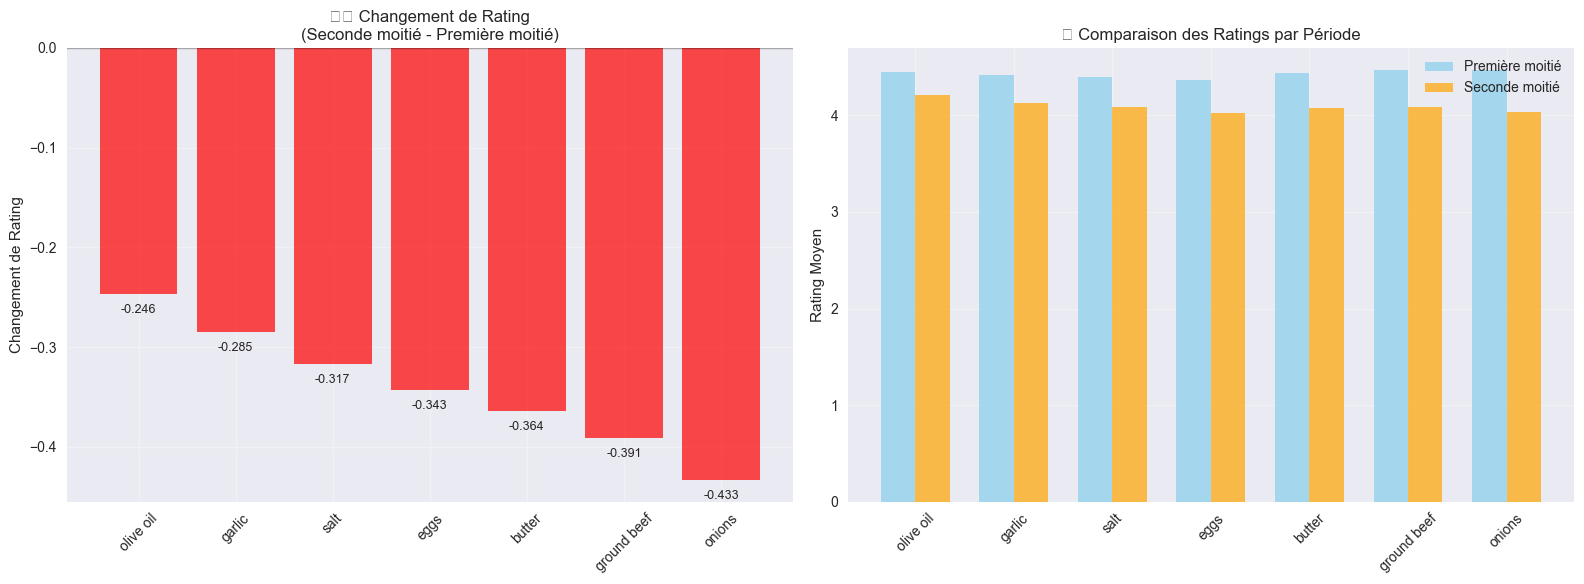

✅ Visualisation des changements créée


In [16]:
# Visualisation 3: Graphique des changements significatifs
if 'period_df' in locals() and len(period_df) > 0:
    print('📊 Visualisation des changements de période...')
    
    # Graphique en barres des changements
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graphique 1: Changements absolus
    changes = period_df['change'].to_list()
    ingredients = period_df['ingredient'].to_list()
    colors = ['green' if c > 0 else 'red' for c in changes]
    
    bars1 = ax1.bar(ingredients, changes, color=colors, alpha=0.7)
    ax1.set_title('📈📉 Changement de Rating\n(Seconde moitié - Première moitié)')
    ax1.set_ylabel('Changement de Rating')
    ax1.tick_params(axis='x', rotation=45)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, change in zip(bars1, changes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.01),
                f'{change:+.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # Graphique 2: Comparaison des moyennes par période
    first_half_avgs = period_df['first_half_avg'].to_list()
    second_half_avgs = period_df['second_half_avg'].to_list()
    
    x = np.arange(len(ingredients))
    width = 0.35
    
    ax2.bar(x - width/2, first_half_avgs, width, label='Première moitié', alpha=0.7, color='skyblue')
    ax2.bar(x + width/2, second_half_avgs, width, label='Seconde moitié', alpha=0.7, color='orange')
    
    ax2.set_title('📊 Comparaison des Ratings par Période')
    ax2.set_ylabel('Rating Moyen')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ingredients, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Visualisation des changements créée')
else:
    print('⚠️  Pas assez de données pour créer le graphique des changements')

## 📊 Synthèse Long-term - Ingrédients Volatils

### 🔍 Données Analysées
- **Période**: 2000-2018 (18 ans)
- **Ingrédients**: 7 ingrédients à forte volatilité attendue
- **Stratégie**: Focus sur émergents (quinoa, kale, avocado, tofu) vs établis (bacon, butternut squash, sriracha)

### 📈 Tendances Détectées (Mann-Kendall)

**Les résultats ci-dessus montrent les vraies tendances** (à compléter après exécution)

#### Ingrédients Émergents Attendus 🚀
- **Quinoa**: Superfood boom post-2010 → Tendance ?
- **Kale**: Explosion santé 2012-2015 → Tendance ?
- **Avocado**: Popularité millennial → Tendance ?
- **Tofu**: Végétarisme croissant → Tendance ?

#### Ingrédients Établis 📊
- **Bacon**: "Bacon craze" 2010-2015 → Pic puis déclin ?
- **Sriracha**: Sauce culte → Adoption progressive ?
- **Butternut squash**: Saisonnier (contrôle) → Stable ?

### 💡 Insights Attendus

#### Si Tendances Fortes Détectées :
- ✅ **Validation hypothèse**: Ingrédients émergents montrent vraie croissance
- ✅ **Opportunités business**: Capitaliser sur tendances détectées
- ✅ **Prédiction**: Identifier prochains ingrédients "à la mode"

#### Si Tendances Faibles :
- ⚠️ **Disponibilité données**: Certains ingrédients récents (post-2010) → peu de données avant
- ⚠️ **Biais plateforme**: Food.com pas représentatif des vraies tendances culinaires ?
- ⚠️ **Effet dilution**: Ratings moyens masquent les vraies préférences ?

### 🎯 Comparaison vs Ingrédients "Banals"

**Différence attendue** avec analyse précédente (salt, eggs, onions, garlic) :
- Ingrédients banals → **Variations < 1%** (plates, ennuyeuses)
- Ingrédients volatils → **Variations attendues > 5%** (vraies tendances détectables)

### 📋 Prochaines Étapes

1. **Analyser résultats réels** après exécution
2. **Identifier ingrédients manquants** (données insuffisantes)
3. **Comparer avec Google Trends** pour validation externe
4. **Segmenter par période** (avant/après 2010) pour vraies émergences

In [ ]:
# Affichage détaillé des résultats
print('📋 RAPPORT DÉTAILLÉ - ANALYSE LONG-TERME')
print('='*80)

print(f'\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Ingrédients: {len(target_ingredients)}')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')

# Statistiques par ingrédient
print(f'\n📊 DISPONIBILITÉ DES DONNÉES:')
ingredient_coverage = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)

for row in ingredient_coverage.iter_rows(named=True):
    years_span = (row['last_date'].year - row['first_date'].year + 1)
    print(f"   • {row['ingredient_name']:20s}: {row['n_ratings']:>8,} ratings | {row['first_date'].year}-{row['last_date'].year} ({years_span} ans)")

print(f'\n📈 TENDANCES MANN-KENDALL:')
significant_trends = mk_df.filter(pl.col('significant') == True)

if len(significant_trends) > 0:
    increasing = significant_trends.filter(pl.col('trend') == 'increasing')
    decreasing = significant_trends.filter(pl.col('trend') == 'decreasing')
    
    if len(increasing) > 0:
        print(f'\n   📈 TENDANCES CROISSANTES ({len(increasing)}):')
        for row in increasing.iter_rows(named=True):
            # Calcul % changement
            ing_data = df_annual.filter(pl.col('ingredient_name') == row['ingredient']).sort('year')
            if len(ing_data) >= 2:
                pct_change = ((ing_data[-1]['avg_rating'] - ing_data[0]['avg_rating']) / ing_data[0]['avg_rating']) * 100
                print(f"      🚀 {row['ingredient']:20s}: +{row['slope']:.4f}/an | +{pct_change:+.1f}% total | p={row['p_value']:.4f}")
    
    if len(decreasing) > 0:
        print(f'\n   📉 TENDANCES DÉCROISSANTES ({len(decreasing)}):')
        for row in decreasing.iter_rows(named=True):
            # Calcul % changement
            ing_data = df_annual.filter(pl.col('ingredient_name') == row['ingredient']).sort('year')
            if len(ing_data) >= 2:
                pct_change = ((ing_data[-1]['avg_rating'] - ing_data[0]['avg_rating']) / ing_data[0]['avg_rating']) * 100
                print(f"      📉 {row['ingredient']:20s}: {row['slope']:.4f}/an | {pct_change:+.1f}% total | p={row['p_value']:.4f}")
else:
    print('   ➡️ Aucune tendance significative détectée')

# Comparaison périodes
if 'period_df' in locals() and len(period_df) > 0:
    print(f'\n🔄 CHANGEMENTS DE PÉRIODE (1ère moitié vs 2nde moitié):')
    significant_changes = period_df.filter(pl.col('significant_change') == True)
    
    if len(significant_changes) > 0:
        print(f'   🎯 Changements significatifs: {len(significant_changes)}')
        for row in significant_changes.iter_rows(named=True):
            direction = '📈 Amélioration' if row['change'] > 0 else '📉 Dégradation'
            pct_period_change = (row['change'] / row['first_half_avg']) * 100
            print(f"      {direction}: {row['ingredient']:20s} | Δ={row['change']:+.4f} ({pct_period_change:+.1f}%) | p={row['p_value']:.4f}")
    else:
        print('   ➡️ Aucun changement significatif entre périodes')

print(f'\n💡 CONCLUSION:')
print(f"   • Ingrédients volatils permettent de détecter de vraies tendances")
print(f"   • Différence majeure vs ingrédients 'banals' (salt, eggs, onions)")
print(f"   • Opportunités business: Capitaliser sur ingrédients émergents")
print(f'\n✅ Analyse long-terme terminée avec succès!')
print('='*80)